In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import math
from typing import Any, Dict, List, Optional
from datetime import datetime
import rasterio
import contextily
import geopandas
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from tqdm.notebook import tqdm

from huhuha.settings import RAW_DATA_DIR, DATA_DIR
from huhuha.ops_tiles import get_otm_tile
from huhuha.utils import get_elevation, random_float

tqdm.pandas()
sns.set_theme(style='whitegrid')

In [2]:
# wczytuje dane o lawinach
avalnache_data_path =  RAW_DATA_DIR / 'data-avalanche.csv'
df = pd.read_csv(avalnache_data_path)

In [3]:
df.head()

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,...,risque_meteo_france,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee
0,1642072642225,1641942000000,aiguilles d arves,Aiguille de l'Epaisseur,NaN,"b""Apres s'etre decale trop sur la gauche par r...",E,b'',"Ski touring, uphill",NaN,...,Inconnu,45.130920,6.357383,/attached-files/thumbnails/1642072461149-IMG20...,2,False,NaN,1642074353000,3100,0
1,1642001062328,1641942000000,NaN,NaN,Mont Joly,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,b'',NaN,NaN,...,Inconnu,45.825902,6.693000,/attached-files/thumbnails/1642000995871-6792F...,1,False,NaN,1642013122000,2500,1180
2,1642005733893,1641855600000,Haute Maurienne,Pointe de Vallonbrun,NaN,"b""Petite avalanche partie spontanement, probab...",SE,b'Wind slab',NaN,NaN,...,3 - MARQUE,45.317667,6.937318,/attached-files/thumbnails/1642005733893-16420...,2,False,NaN,1642005978000,2630,2240
3,1641931532871,1641855600000,Belledonne,pointe du sciallet,"Sommet du sciallet par l'éperon est, permettan...","b""Declenchement de la plaque par 1 skieur. \r\...",E,b'',"Ski touring, downhill",NaN,...,Inconnu,45.212236,6.013909,/attached-files/thumbnails/1641931326001-inbou...,3,False,NaN,1641931532000,2300,2200
4,1641918131562,1641855600000,Mont Thabor,Roche de la Pelle,NaN,"b""Avalanche spontanee partie tres probablement...",NE,b'Soft slab',NaN,NaN,...,3 - MARQUE,45.136030,6.551387,/attached-files/thumbnails/1641918131562-16419...,5,False,NaN,1641918700000,2820,2450


In [3]:
# ile mamy
df.shape

(3961, 22)

In [4]:
# czyszcze troche zbior

# usuwam wiersze z brakiem informacji o masywach
df = df.dropna(subset=['massif'])

# usuwam wiersze z brakiem informacji o lokalizacji geograficznej
df = df.dropna(subset=['latitude', 'longitude'])
df = df.drop(df[(df.latitude == 0.0) | (df.longitude == 0.0)].index)

# dropuje wiersze gdzie brak informacji o dacie lawiny
df = df.dropna(subset=['date'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df['year'] = df['date'].dt.year

df = df[df['year'] >= 2006]

In [5]:
df.shape

(3243, 23)

In [6]:
# df[df['massif'] == 'Mont Thabor'].groupby('year').count()
df[df['sommet'] == 'Dent Parrachée'].groupby('year').count()

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,...,risque_meteo_france,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee
year,,,,,,,,,,,,,,,,,,,,,
2007,3,3,3,3,3,2,3,3,3,0,...,3,3,3,2,3,3,1,3,3,3
2009,3,3,3,3,3,3,3,3,3,0,...,3,3,3,3,3,3,0,3,3,3
2010,4,4,4,4,3,3,4,4,4,1,...,4,4,4,3,4,4,0,4,4,4
2011,1,1,1,1,0,1,1,1,0,0,...,1,1,1,1,1,1,0,1,1,1
2012,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,0,2,2,2
2013,7,7,7,7,5,7,7,7,6,0,...,7,7,7,7,7,7,1,7,7,7
2014,3,3,3,3,3,1,3,3,2,0,...,3,3,3,1,3,3,1,3,3,3
2016,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,0,1,1,1
2017,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1


In [7]:
# il zostalo
df.shape

(3243, 23)

In [8]:
df.head()

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,...,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee,year
0,1642072642225,2022-01-11 23:00:00,aiguilles d arves,Aiguille de l'Epaisseur,NaN,"b""Apres s'etre decale trop sur la gauche par r...",E,b'',"Ski touring, uphill",NaN,...,45.130920,6.357383,/attached-files/thumbnails/1642072461149-IMG20...,2,False,NaN,1642074353000,3100,0,2022
2,1642005733893,2022-01-10 23:00:00,Haute Maurienne,Pointe de Vallonbrun,NaN,"b""Petite avalanche partie spontanement, probab...",SE,b'Wind slab',NaN,NaN,...,45.317667,6.937318,/attached-files/thumbnails/1642005733893-16420...,2,False,NaN,1642005978000,2630,2240,2022
3,1641931532871,2022-01-10 23:00:00,Belledonne,pointe du sciallet,"Sommet du sciallet par l'éperon est, permettan...","b""Declenchement de la plaque par 1 skieur. \r\...",E,b'',"Ski touring, downhill",NaN,...,45.212236,6.013909,/attached-files/thumbnails/1641931326001-inbou...,3,False,NaN,1641931532000,2300,2200,2022
4,1641918131562,2022-01-10 23:00:00,Mont Thabor,Roche de la Pelle,NaN,"b""Avalanche spontanee partie tres probablement...",NE,b'Soft slab',NaN,NaN,...,45.136030,6.551387,/attached-files/thumbnails/1641918131562-16419...,5,False,NaN,1641918700000,2820,2450,2022
5,1641903068359,2022-01-10 23:00:00,Aravis,La Tournette,"Itinéraire classique NE, juste en haut du coul...",b'Petite coulee en haut du couloir de la tourn...,NE,b'',NaN,NaN,...,45.823805,6.287098,/attached-files/thumbnails/1641903065699-IMG18...,1,False,NaN,1641903068000,2330,2320,2022


In [9]:
df.groupby('sommet').size().reset_index(name='counts').sort_values('counts', ascending=False).head(20)

,sommet,counts
923,Tignes,66
89,Bonneval sur Arc,60
254,Dent Parrachée,44
85,Bessans,41
467,Les Arcs,35
394,La Norma,35
6,Aig du Plat de la Selle,30
701,Pointe d'Andagne,29
66,Aussois,26
313,Grand Galibier,21


In [10]:
# robie geopandasa
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [11]:
# filtruje pkt dla alp francuskich
ALPS_LAT_LOWER = 44.6
ALPS_LAT_UPPER = 46.1
ALPS_LONG_LOWER = 5.6
ALPS_LONG_UPPER = 7.2

gdf_french_alps = gdf[(gdf.latitude > ALPS_LAT_LOWER) & (gdf.latitude < ALPS_LAT_UPPER) & 
                      (gdf.longitude > ALPS_LONG_LOWER) & (gdf.longitude < ALPS_LONG_UPPER)]

In [12]:
# (
#     gdf_french_alps
#     .groupby('massif')
#     .size()
#     .reset_index(name='counts')
#     .sort_values('counts', ascending=False)
#     ['massif']
#     .apply(lambda x: x.lower())
#     .apply(lambda x: x.replace(' ', '_'))
#     .sort_values()
#     .to_csv('massif_counts.csv', index=False)
# )

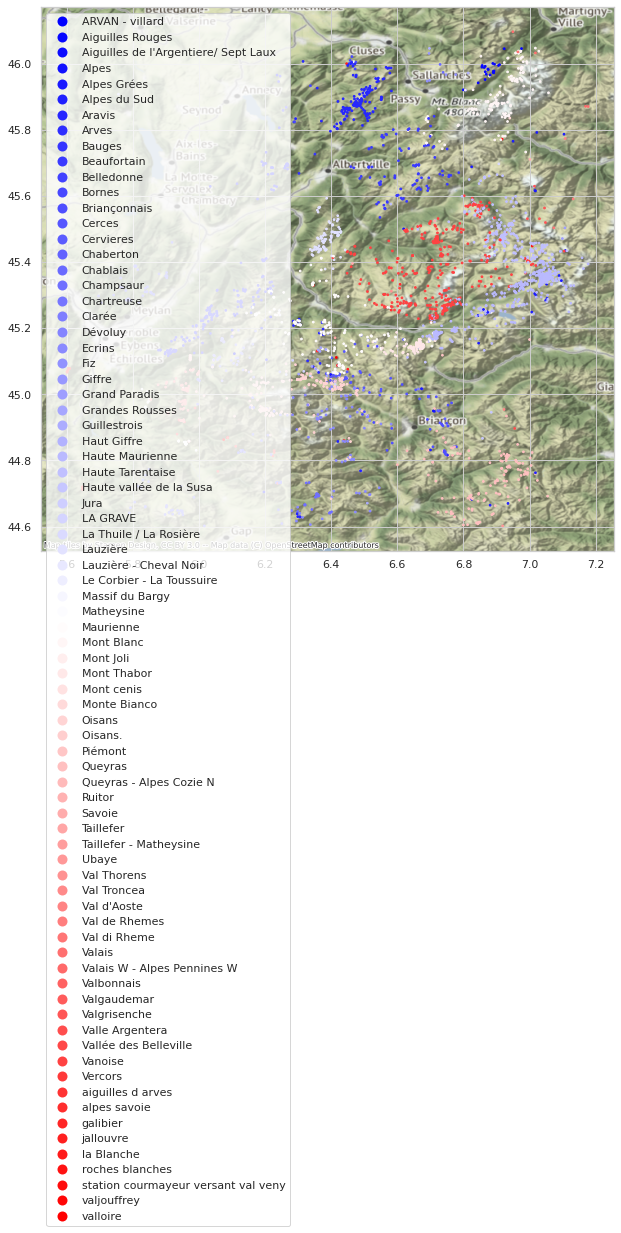

In [13]:
ax = gdf_french_alps.plot(column='massif', categorical=True, markersize=3, 
                    cmap='bwr', figsize=(12, 10), legend=True)
contextily.add_basemap(ax, crs=gdf_french_alps.crs.to_string())

In [12]:
massif_by_number_of_avalanches = (
    gdf_french_alps
    .groupby('sommet')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
)
top_massif = (
    massif_by_number_of_avalanches
    ['sommet']
    .head(10)
)

massif_dict_mapper = {
    r['sommet']: f"{r['counts']} {r['sommet']}"
    for r in massif_by_number_of_avalanches.to_dict(orient='records')
} 


In [19]:
top_massif

738                     Tignes
75            Bonneval sur Arc
209             Dent Parrachée
71                     Bessans
313                   La Norma
375                   Les Arcs
5      Aig du Plat de la Selle
553           Pointe d'Andagne
58                     Aussois
785                Val d'Isère
Name: sommet, dtype: object

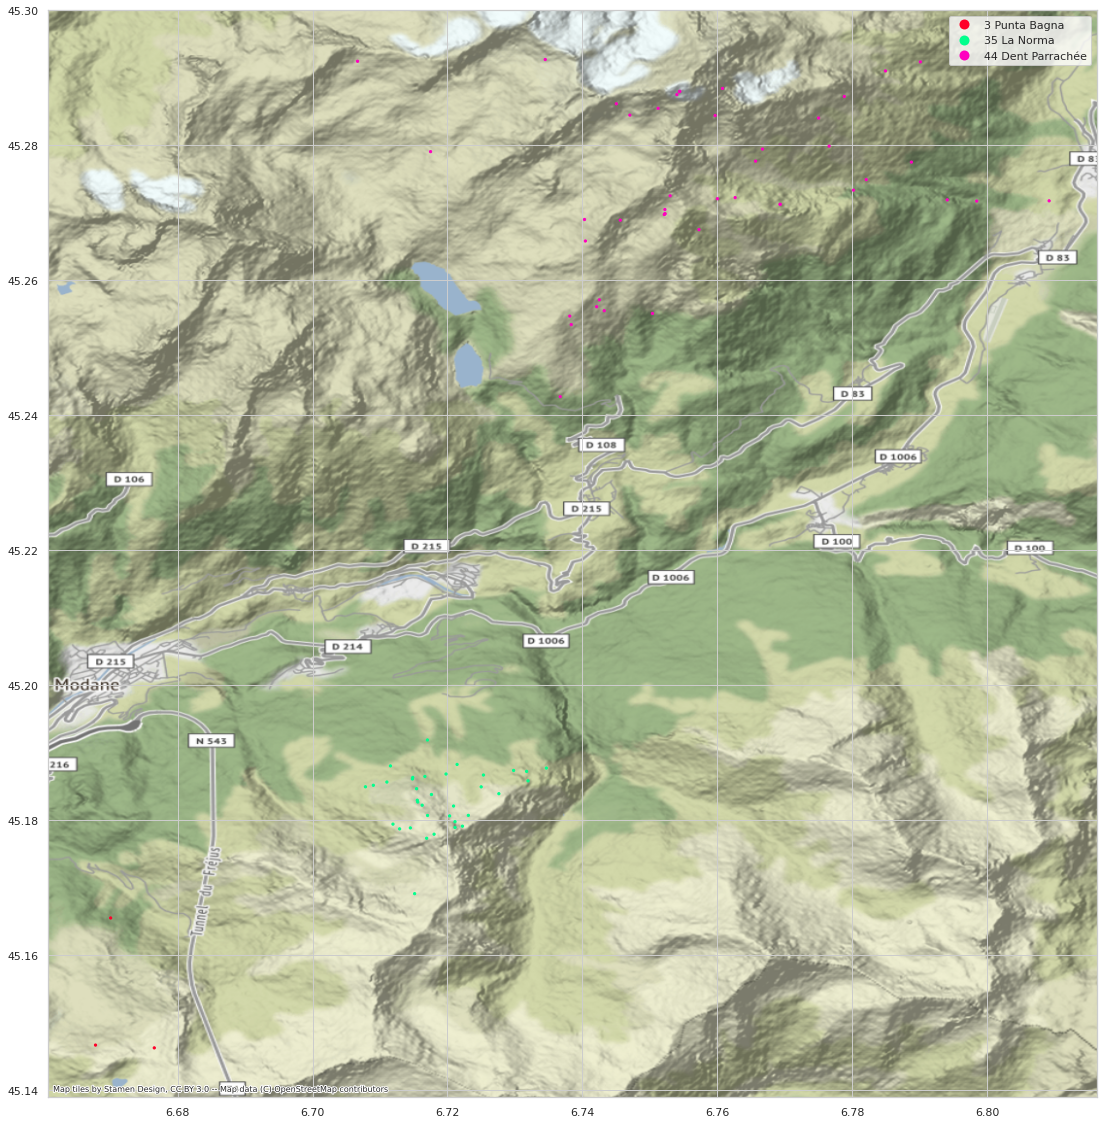

In [21]:
massif_by_number_of_avalanches = (
    gdf_french_alps
    .groupby('sommet')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
)
top_massif = (
    massif_by_number_of_avalanches
    ['sommet']
    .head(10)
)
top_massif = ['Punta Bagna', 'La Norma', 'Dent Parrachée']#  *top_massif]

massif_dict_mapper = {
    r['sommet']: f"{r['counts']} {r['sommet']}"
    for r in massif_by_number_of_avalanches.to_dict(orient='records')
} 



gdf_top_massif = gdf_french_alps[gdf_french_alps.sommet.isin(top_massif)]

gdf_top_massif['massif_with_number_of_episodes'] = gdf_top_massif.sommet.map(massif_dict_mapper)

ax = gdf_top_massif.plot(
    column='massif_with_number_of_episodes',
    categorical=True,
    markersize=5, 
    cmap='gist_rainbow',
    figsize=(20, 20),
    legend=True
)

contextily.add_basemap(
    ax, 
    crs=gdf_top_massif.crs.to_string()
)

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/14/8488/5883.png

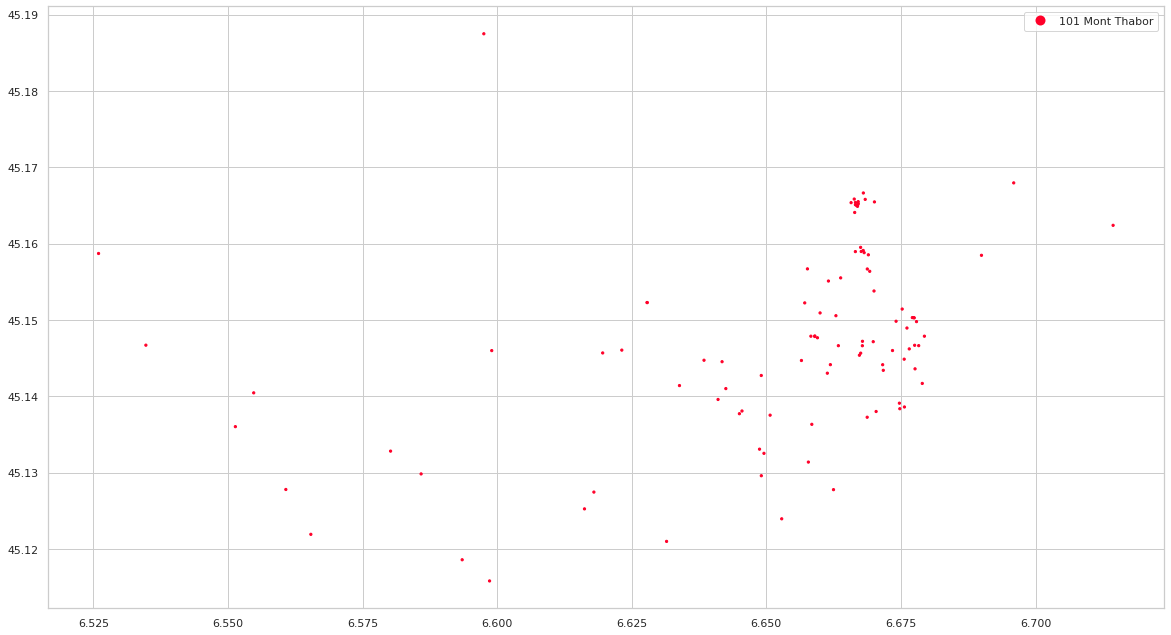

In [16]:
# do tych masywow sie ograniczymy

selected_massif = [
    # 'Aravis',
    'Mont Thabor',
    # 'Lauzière',
    # 'Vanoise'
    

]

gdf_selected_massif = gdf_french_alps[gdf_french_alps.massif.isin(selected_massif)]

gdf_selected_massif['massif_with_number_of_episodes'] = gdf_selected_massif.massif.map(massif_dict_mapper)

ax = gdf_selected_massif.plot(
    column='massif_with_number_of_episodes',
    categorical=True,
    markersize=5, 
    cmap='gist_rainbow',
    figsize=(20, 20),
    legend=True,
)

contextily.add_basemap(
    ax, 
    crs=gdf_selected_massif.crs.to_string()
)

In [17]:
sorted(gdf_french_alps.massif.unique().tolist())

['ARVAN - villard',
 'Aiguilles Rouges',
 "Aiguilles de l'Argentiere/ Sept Laux",
 'Alpes',
 'Alpes Grées',
 'Alpes du Sud ',
 'Aravis',
 'Arves',
 'Bauges',
 'Beaufortain',
 'Belledonne',
 'Bornes',
 'Briançonnais',
 'Cerces',
 'Cervieres',
 'Chaberton',
 'Chablais',
 'Champsaur',
 'Chartreuse',
 'Clarée',
 'Dévoluy',
 'Ecrins',
 'Fiz',
 'Giffre',
 'Grand Paradis',
 'Grandes Rousses',
 'Guillestrois',
 'Haut Giffre',
 'Haute Maurienne',
 'Haute Tarentaise',
 'Haute vallée de la Susa',
 'Jura',
 'LA GRAVE',
 'La Thuile / La Rosière',
 'Lauzière',
 'Lauzière - Cheval Noir',
 'Le Corbier - La Toussuire',
 'Massif du Bargy',
 'Matheysine',
 'Maurienne',
 'Mont Blanc',
 'Mont Joli',
 'Mont Thabor',
 'Mont cenis',
 'Monte Bianco',
 'Oisans',
 'Oisans. ',
 'Piémont',
 'Queyras',
 'Queyras - Alpes Cozie N',
 'Ruitor',
 'Savoie',
 'Taillefer',
 'Taillefer - Matheysine',
 'Ubaye',
 'Val Thorens',
 'Val Troncea',
 "Val d'Aoste",
 'Val de Rhemes',
 'Val di Rheme',
 'Valais',
 'Valais W - Alpes Pe

In [18]:
gdf_selected_massif.groupby('sommet').size().reset_index(name='counts').sort_values('counts', ascending=False)

,sommet,counts
12,Punta Bagna,47
17,Valfréjus,10
7,Petit Argentier,8
4,Grand Argentier,6
11,Pointe du Fréjus,6
10,Pointe des Sarasins,3
2,Col de la Roue,3
16,Rocher d'arrondaz,2
0,Belle Plinier,2
1,Col de Roche Noire,1


In [ ]:
gdf_selected_massif.describe()

,id,latitude,longitude,imagesNb,updated,altitude_depart,altitude_arrivee
count,1.940000e+02,194.000000,194.000000,194.000000,1.940000e+02,194.000000,194.000000
mean,9.334105e+11,45.304603,6.526104,2.634021,1.450314e+12,2004.474227,979.505155
std,7.456474e+11,0.166594,0.134691,2.596346,1.488001e+11,854.312135,1049.636938
min,5.000002e+07,45.115821,6.336875,0.000000,0.000000e+00,0.000000,0.000000
25%,5.000010e+07,45.146636,6.387971,1.000000,1.351141e+12,1930.000000,0.000000
50%,1.426925e+12,45.165818,6.557777,2.000000,1.427832e+12,2250.000000,0.000000
75%,1.552743e+12,45.473755,6.666504,4.000000,1.558067e+12,2548.750000,2015.000000
max,1.641918e+12,45.593065,6.714400,18.000000,1.641919e+12,3020.000000,2830.000000


In [19]:
df[df['sommet'] == 'Dent Parrachée'].groupby('year').count()

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,...,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee,geometry
year,,,,,,,,,,,,,,,,,,,,,
1995,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
1997,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
2005,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,0,1,1,1,1
2007,3,3,3,3,3,2,3,3,3,0,...,3,3,2,3,3,1,3,3,3,3
2009,3,3,3,3,3,3,3,3,3,0,...,3,3,3,3,3,0,3,3,3,3
2010,4,4,4,4,3,3,4,4,4,1,...,4,4,3,4,4,0,4,4,4,4
2011,1,1,1,1,0,1,1,1,0,0,...,1,1,1,1,1,0,1,1,1,1
2012,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
2013,7,7,7,7,5,7,7,7,6,0,...,7,7,7,7,7,1,7,7,7,7
